<h1> simplified JPEG encoder/decoder</h1>

**Read the guidance**

**Read the topic (.pdf file) first**

**Some given functions:** (in Section 2)
  - zigzag
  - functions related to Huffman coding, such as ``construct_huffman_table, encode_huffman, decode_huffman``

**Functions to be implemented:**
  - rlencode (in Section 1)
  - count_symbols (in Section 1)
  - and also the 'main' functions (in Section 3)

**Some useful functions:** 
  - imshow()
  - img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
  - cv2.dct

**You can directly go to Section 3 and code there**

**Import the libs**

In [2]:
import numpy as np  
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Any, Dict, Optional

import cv2

def show(img:np.ndarray):
    im = Image.fromarray(img)
    print(im.size, im.mode, im.format, img.min(),  img.max())
    display(im)

def load_from_url(url: str) -> np.ndarray:
    return np.asarray(Image.open(requests.get(url, stream=True).raw))

def debug_ndarray(arr:np.ndarray, name:str='') -> None:
    print(name, arr.shape, arr.dtype, arr.min(), arr.max())

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# 1. Functions to be implemented

*   rlencode: Run length coding
*   count_symbols: this will be used for Huffman coding
*   zigzag: optional (since there will be a quite easy 'manual' way for doing that)
*   **Note: however, you dont need to implement these functions immediately. You can go to Section 3 to implement different first steps of JPEG: block devivision, centering, DCT, quantification.** 





In [5]:
from collections import Counter
def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output
    

def rlencode(data:list, symbol:int=0, escape=257) -> np.ndarray:
    '''
    Encode a list of values using run length encoding
    when `symbol` is encountered, 
    the next value is `escape` followed by the number of `symbol`.
    '''
    out = []
    count = 0
    for value in data:
        if value == symbol:
            out.append(escape)
            out.append(count)
            count = 0
        else:
            out.append(value)
            count += 1
    return np.array(out)

def count_symbols(data:list) -> Dict[Any, int]:
    '''
    Compute the frequency of each value in the list
    '''
    freq = Counter(data)
    return dict(freq)

    
#testing
freq = count_symbols([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])
print(freq)
#'output: {0: 4, 1: 3, 2: 2, 3: 1}'


{0: 4, 1: 3, 2: 2, 3: 1}


#2. Given functions

**Huffman tree**

To obtain the Huffman code, it is necessary to construct a (binary) Huffman tree.
This tree is constructed from a list of leaves (symbols) and internal nodes (sum of the weights of the children).
Each node is associated with a value which is the sum of the values of its children.
The leaves correspond to symbols and are associated with their number of occurrences in the vector.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/1200px-Huffman_tree_2.svg.png" width=500>

Huffman encoding involves counting the number of occurrences of each character in a sentence and representing each character as a leaf node on a tree with a weight equal to its occurrence count. The tree is constructed by combining the two nodes with the lowest weights at each step until only one node, the root of the tree, remains.

In [6]:
def compute_huffman_tree(data:list, freq:Optional[dict]=None) -> Tuple[int, Any, Any]:
    '''
    Compute a huffman tree from a frequency table of values
    Return the root node of the tree
    '''
    if freq is None:
        freq: Dict[Any, int] = count_symbols(data)

    # create a list of nodes
    nodes = []
    for symbol, freq in freq.items():
        nodes.append((freq, symbol))
    
    # sort the list of nodes by count
    nodes.sort(key=lambda x: x[0])

    # create a tree
    while len(nodes) > 1:
        # get the two lowest frequency nodes
        left, right = nodes[:2]
        
        # create a new node with the sum of the frequencies
        new_node_count = left[0] + right[0]
        new_node = (new_node_count, left, right)
        # remove the two lowest frequency nodes
        nodes = nodes[2:]
        # insert the new node
        nodes.append(new_node)
        # sort the nodes by frequency
        nodes.sort(key=lambda x: x[0])

    # return the root node
    return nodes[0]

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)

from pprint import pprint

data_tree = compute_huffman_tree(data)
pprint(data_tree)

(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))


**Huffman coding table**

Read and test the following functions

In [7]:
def display_table(lines, code:dict, sep='\t'):
    '''
    Display a table of data with columns aligned
    '''
    cols_width = [max(len(str(x)) for x in col) for col in zip(*lines)]
    for line in lines:
        # adjust each column to its max width
        print(*[x.rjust(w) for x, w in zip(line, cols_width)], sep=sep)

def display_huffman_table(data, code:dict, sep='\t'):
    counts: dict = count_symbols(data)
    total = sum(counts.values())
    lines = [('Symbol', 'Code', 'Count', 'Frequency')]
    tmp = sorted(list(counts.keys()), key=lambda x: counts[x], reverse=True)
    for k in tmp:
        symbol = f"`{k}`"
        symbol_code = str(counts[k])
        count = str(code[k])
        freq = str(round(100 * counts[k] / total, 2))+'%'
        lines.append((symbol, symbol_code, count, freq))
    display_table(lines, code, sep=sep)

def bintree_to_table(node, path=None, left='0', right='1') -> Dict[str, str]:
    '''
    Build a huffman table from a huffman tree
    Return a dictionary of symbol:code
    '''
    if path is None:
        path = ''
    table = {}
    if len(node) == 2: # leaf node
        count, symbol = node
        table[symbol] = path
    else: # internal node
        node_left, node_right = node[1], node[2]
        left_path = bintree_to_table(node_left, path + left, left=left, right=right)
        right_path = bintree_to_table(node_right, path + right, left=left, right=right)
        table.update(left_path)
        table.update(right_path)
    
    return table

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
data_tree = compute_huffman_tree(data)
data_table = bintree_to_table(data_tree)

# display the huffman table
display_huffman_table(data, data_table)


Symbol	Code	Count	Frequency
   ` `	   7	  111	   19.44%
   `a`	   4	  000	   11.11%
   `e`	   4	  001	   11.11%
   `f`	   3	 1101	    8.33%
   `t`	   2	 0100	    5.56%
   `h`	   2	 0101	    5.56%
   `i`	   2	 0110	    5.56%
   `s`	   2	 0111	    5.56%
   `n`	   2	 1000	    5.56%
   `m`	   2	 1001	    5.56%
   `x`	   1	10100	    2.78%
   `p`	   1	10101	    2.78%
   `l`	   1	10110	    2.78%
   `o`	   1	10111	    2.78%
   `u`	   1	11000	    2.78%
   `r`	   1	11001	    2.78%


***Take time to test the three following functions, you will use them for Huffman codage/decodage***

In [12]:
def construct_huffman_table(data:list) -> dict:
    '''
    Encode a list of values using huffman encoding and return the huffman table
    '''
    counts = count_symbols(data)
    tree = compute_huffman_tree(counts)
    table = bintree_to_table(tree)
    return table

def encode_huffman(data: list, table: dict) -> str:
    '''
    Encode a list of values using the huffman table dictionary
    Return the encoded string
    '''
    out = []
    for i in data:
        out.extend(table[i])
    out = ''.join(out) # list to string
    return out

def decode_huffman(encoded:str, table: dict) -> np.ndarray:
    '''
    Decode a list of values using huffman code dictionary
    '''
    data = []
    i = 0
    while i < len(encoded):
        for k, v in table.items():
            if encoded[i:].startswith(v): # prefix match
                data.append(k)
                i += len(v)
                break
    return np.array(data)

# testing
sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
table = construct_huffman_table(data)
print("Test 1")
print(table)
#display_huffman_table(data, table)

# Testing
print("Test 2")
data = [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
data_table = construct_huffman_table(data)
print('data table :', data_table)
print('Original :', data)

encoded = encode_huffman(data, data_table)
print('Encoded  :', encoded)

decoded = decode_huffman(encoded, data_table)
print('Decoded  :', decoded)


Test 1
{'a': '000', 'e': '001', 't': '0100', 'h': '0101', 'i': '0110', 's': '0111', 'n': '1000', 'm': '1001', 'x': '10100', 'p': '10101', 'l': '10110', 'o': '10111', 'u': '11000', 'r': '11001', 'f': '1101', ' ': '111'}
Test 2
data table : {1: '000', 3: '001', 2: '010', 4: '011', 0: '1'}
Original : [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
Encoded  : 1000111110101011011010001
Decoded  : [0 1 0 0 0 0 0 2 0 4 4 2 3]


#3. TODO: Codage/Decodage

In [14]:
# ZigZag example

# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])

rdMatrix = np.round(np.random.rand(8,8)*10)

out = np.zeros(64)
for k in range(64):
    out[k] = rdMatrix[lig[k]-1,col[k]-1] # -1 since indexes start from 0 in Python...

print(rdMatrix)
print('ZigZag:',out)


[[ 3.  3.  2.  2.  5.  8.  4.  2.]
 [ 8.  3.  8.  4.  7.  5.  1.  3.]
 [ 3.  9.  2.  1.  1.  6.  0.  9.]
 [ 2. 10.  5.  4.  9.  9.  1. 10.]
 [ 0.  4.  0.  6.  0. 10.  5.  8.]
 [ 2.  5.  2.  5.  9.  5.  3.  6.]
 [ 2.  2.  2.  8.  2.  4.  3.  5.]
 [ 8.  7. 10.  0.  6.  4.  4.  1.]]
ZigZag: [ 3.  3.  8.  3.  3.  2.  2.  8.  9.  2.  0. 10.  2.  4.  5.  8.  7.  1.
  5.  4.  2.  2.  5.  0.  4.  1.  5.  4.  2.  1.  6.  9.  6.  2.  2.  8.
  7.  2.  5.  0.  9.  0.  3.  9.  1. 10.  9.  8. 10.  0.  2.  5.  5. 10.
  8.  3.  4.  6.  4.  3.  6.  5.  4.  1.]


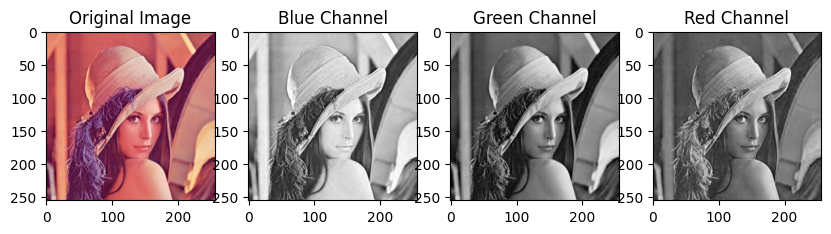

In [18]:
# define quantization tables
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

# read an image and show it
url = "http://www.lenna.org/len_std.jpg"
imgOriginal = load_from_url(url)
#show(imgOriginal)

#TODO: show different channels
# Split the image into different channels
b, g, r = cv2.split(imgOriginal)

# Display the different channels
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(imgOriginal)
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(b, cmap='gray')
plt.title('Blue Channel')

plt.subplot(1, 4, 3)
plt.imshow(g, cmap='gray')
plt.title('Green Channel')

plt.subplot(1, 4, 4)
plt.imshow(r, cmap='gray')
plt.title('Red Channel')

plt.show()

In [ ]:
"""""
# For students
# TODO: Write your 'main' code 
# convert color image into gray image (or image in YCrCb space)

# This is just an example of coding, you can make your code differently

# ADVICE: create an other 'Code cell' and write/test your code gradually there 
# since the code given here is not exectable yet 

img = cv2.cvtColor(...)
# color
# First, you can work with only gray images for simplicity


width = len(img[0])
height = len(img)

# 
img_gray = np.zeros((height, width), np.float32) + img[:, :, 0]
#

#show img_gray

# define block size

# compute number of blocks

# padding

# luminance channels

# for color images -----
# chrominance channels should be sub-sampled with different sub-sampling factors
# A very simple way: using a 2x2 averaging filter # another type of filter can be used
# then we can work with the sub-sampled version...
#--------------------

# define empty matrices to store Dct
# imgDct

# define empty matrices to store the quantized values
# imgQ


# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])


ZZ_Blk = np.zeros(blockSize * blockSize) #1D

vRLC = []

size_vRLC = 0

#pseudo-code
for i in range('number of block'): #of course, this needs to be computed
    for j in range('number of block'):
        block = y[ ....]). # extract the block

        # dct
        # you can use something like imgDct['index'] = ...
        
        # quantification
        # you can use something like imgQ['index'] = ...
              
        # easy ZigZag Version 2: 
        ZZ_Blk = ...#      
        # zigzag (1D)
        
        # run length coding (1D)
        # can use `extend` function of numpy vRLC.extend()

#end for


# Huffman
mat_table: dict = construct_huffman_table...
mat_encoded: str = encode_huffman...

"""

In [27]:
img = imgOriginal
width = len(img[0])
height = len(img)

img_gray = np.zeros((height, width), np.float32) + img[:, :, 0]

# define block size
blockSize = 8

# compute number of blocks
numBlocksW = width // blockSize
numBlocksH = height // blockSize

# padding
paddedWidth = numBlocksW * blockSize
paddedHeight = numBlocksH * blockSize
paddedImg = np.pad(img_gray, ((0, paddedHeight - height), (0, paddedWidth - width)), mode='constant')

# luminance channels
Y = paddedImg

# for color images -----
# chrominance channels should be sub-sampled with different sub-sampling factors
# A very simple way: using a 2x2 averaging filter # another type of filter can be used
# then we can work with the sub-sampled version...
#--------------------

# define empty matrices to store Dct
imgDct = np.zeros((numBlocksH, numBlocksW, blockSize, blockSize))

# define empty matrices to store the quantized values
imgQ = np.zeros((numBlocksH, numBlocksW, blockSize, blockSize))

# define empty list to store run length coding
vRLC = []

# pseudo-code
for i in range(numBlocksH):
    for j in range(numBlocksW):
        block = Y[i * blockSize: (i + 1) * blockSize, j * blockSize: (j + 1) * blockSize]

        # dct
        imgDct[i, j] = cv2.dct(block)

        # quantization
        imgQ[i, j] = np.round(imgDct[i, j] / qY)

        # easy ZigZag Version 2:
        ZZ_Blk = imgQ[i, j].ravel()[np.argsort(lig * blockSize + col)]

        # run length coding (1D)
        vRLC.extend(ZZ_Blk)

# end for

# calculate the size of vRLC
size_vRLC = len(vRLC)

# Huffman
mat_table = construct_huffman_table(vRLC)
mat_encoded = encode_huffman(vRLC, mat_table)

print('Huffman table:', mat_table)
print('Huffman encoded:', mat_encoded)


Huffman table: {6.0: '0000000', 76.0: '0000001000', 49.0: '0000001001', 17.0: '0000001010', 14.0: '0000001011', 105.0: '000000110', 60.0: '0000001110', 99.0: '0000001111', 9.0: '00000100', -9.0: '00000101', 104.0: '000001100', 114.0: '0000011010', 86.0: '0000011011', 90.0: '0000011100', 50.0: '0000011101', 19.0: '00000111100', 74.0: '00000111101', 20.0: '00000111110', 46.0: '00000111111', -4.0: '000010', 77.0: '00001100000', -26.0: '00001100001', 73.0: '00001100010', 75.0: '00001100011', 111.0: '000011001', 113.0: '000011010', 118.0: '0000110110', 94.0: '0000110111', 55.0: '0000111000', 88.0: '0000111001', 110.0: '000011101', -8.0: '00001111', 7.0: '00010000', 92.0: '0001000100', 117.0: '0001000101', 107.0: '0001000110', -15.0: '0001000111', 84.0: '00010010000', 22.0: '00010010001', 18.0: '00010010010', 79.0: '00010010011', 57.0: '00010010100', 85.0: '00010010101', 52.0: '00010010110', -19.0: '00010010111', 72.0: '00010011000', 59.0: '00010011001', 70.0: '00010011010', 124.0: '00010011

**Compute compression rates at different stages**

In [28]:
# Calculate the number of bits (original)
numPixels = width*height
numBitsOriginal = numPixels * 8

# Calculate the number of elements (yRLC)
numElementsYRLC = np.count_nonzero(vRLC)

# Calculate the number of bits (encoded)
numBitsEncoded = len(mat_encoded)

# Calculate the compression ratio
compressionRatio = numBitsOriginal / numBitsEncoded

# Print the results
print("Number of bits (original):", numBitsOriginal)
print("Number of elements (yRLC):", numElementsYRLC)
print("Number of bits (encoded):", numBitsEncoded)
print("Compression ratio:", compressionRatio)

Number of bits (original): 524288
Number of elements (yRLC): 9488
Number of bits (encoded): 105530
Compression ratio: 4.968141760636786


**Decodage**

In [29]:
# Huffman decoding
decoded = decode_huffman(mat_encoded, mat_table)
print(len(decoded))

65536


In [30]:
print(decoded)

[113.   0.   0. ...   0.   0.   0.]


In [32]:
decoded - vRLC

array([0., 0., 0., ..., 0., 0., 0.])